# Proposta para OSS2025
![Terceira Arquitetura do Grupo](arc3.png)

- tentar ver o que a yolo está a detetar
- vale a pena usar os 4
- referenciar o artigo
- fine tuning pontual
- criar readme com todos os imports
- gpu a 0 e sem memoria, tem que levar reset


## O que pode ser "Tuned"

### Clip
- Versão do CLIP -> (https://pypi.org/project/open-clip-torch/)
- Escolher os pesos/pre-treino
- Shape: atualmente (8,3,244,244) # T,C,H,W
### R3D
- R3D com ou sem pre-treino -> (https://docs.pytorch.org/vision/main/models/generated/torchvision.models.video.r3d_18.html#torchvision.models.video.r3d_18)
- Shape: atualmente (4,16,3,244,244)
- Pode ser alterado para outro transformer, tipo Video Swin
### Yolo
- Versão da Yolo (https://docs.ultralytics.com/pt/#where-to-start)
- Qual camada intermédia escolher para o hook: atualmente -10
- Shape: atualmente (3,640,640) # C,H,W

### Temporal Transfomer
- Número de cabeças
- Número de camadas
- Número de Features FeadFoward, convém ser o mesmo que visual_dim
- Regularização dropout

### Cross Transformer

- Número de cabeças
- Número de camadas

### Geral
- O tamanho das projeções: visual_dim = 512
- O tamanho do Batch: atualmente a 2
- O Número de clips 2D: 8
- O Número de clips 3D: 4
- O Número de frames por clip 3d: 16

# Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image
import open_clip
import gc
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.optim import SGD, Adam
import cv2

import torchvision.transforms as transforms
from torchvision.io import read_video
import torchvision.io as tvio   
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary
from torch.utils.data import Dataset
from torchvision.io import read_video
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler


from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


# Dataset

In [3]:
class MultiStreamVideoDataset(Dataset):
    def __init__(
        self,
        video_dir,
        label_path,
        clip_preprocess,
        num_2d_frames=8,
        num_3d_clips=4,
        frames_per_clip=16,
        transform_3d=None,
        yolo_resize=None,
        label_map=None
    ):
        self.video_dir = video_dir
        self.clip_preprocess = clip_preprocess
        self.num_2d_frames = num_2d_frames
        self.num_3d_clips = num_3d_clips
        self.frames_per_clip = frames_per_clip

        self.transform_3d = transform_3d or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ConvertImageDtype(torch.float32)
        ])

        # Resize for YOLO input (usually trained with 640×640)
        self.yolo_resize = yolo_resize or transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor()
        ])

        self.labels_dict = self._load_labels(label_path)

        self.videos = [
            f for f in os.listdir(video_dir)
            if f.endswith(".mp4") and os.path.splitext(f)[0] in self.labels_dict
        ]
        print(f"Found {len(self.videos)} labeled videos")

        if label_map:
            self.label_map = label_map
        else:
            unique_labels = sorted(set(self.labels_dict.values()))
            self.label_map = {name: i for i, name in enumerate(unique_labels)}

    def _load_labels(self, path):
        if not os.path.exists(path):
            print(f"Warning: Label file not found: {path}")
            return {}

        try:
            # Check file extension and load appropriately
            file_ext = os.path.splitext(path)[1].lower()
            
            if file_ext in ['.xls', '.xlsx']:
                df = pd.read_excel(path, header=0)
            elif file_ext == '.csv':
                df = pd.read_csv(path, header=0, sep=";")
            else:
                print(f"Unsupported file extension: {file_ext}. Expected .xls, .xlsx, or .csv")
                return {}

            if "VIDEO" not in df.columns or "GLOBA_RATING_SCORE" not in df.columns:
                raise ValueError("Required columns not found.")

            df = df.drop(columns=[c for c in ["STUDENT", "GROUP", "TIME", "SUTURES", "INVESTIGATOR"] if c in df.columns])
            df = df.groupby("VIDEO").mean()

            df["TARGET_CLASS"] = df["GLOBA_RATING_SCORE"].apply(
                lambda x: "novice" if 8 <= x < 16 else
                          "intermediate" if 16 <= x < 24 else
                          "proficient" if 24 <= x < 32 else
                          "expert" if 32 <= x <= 40 else "unknown"
            )

            df = df[df["TARGET_CLASS"] != "unknown"]
            return dict(zip(df.index, df["TARGET_CLASS"]))
        except Exception as e:
            print(f"Error loading labels: {e}")
            return {}
    def __len__(self):
        return len(self.videos)

    def _sample_indices(self, total_frames, num_samples):
        if total_frames == 0:
            raise ValueError("Total frames is zero, cannot sample indices.")
        if total_frames < num_samples:
            return [i % total_frames for i in range(num_samples)]
        return sorted(random.sample(range(total_frames), num_samples))

    def _cv2_to_tensor(self, frame):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame_rgb)

    def __getitem__(self, idx):
        video_file = self.videos[idx]
        video_name = os.path.splitext(video_file)[0]
        label_str = self.labels_dict[video_name]
        label = self.label_map[label_str]

        video_path = os.path.join(self.video_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        idx_2d = self._sample_indices(total_frames, self.num_2d_frames)

        clip_start_indices = []
        for _ in range(self.num_3d_clips):
            if total_frames < self.frames_per_clip:
                start_idx = 0
            else:
                start_idx = random.randint(0, total_frames - self.frames_per_clip)
            clip_start_indices.append(start_idx)

        clip_indices = []
        for start_idx in clip_start_indices:
            clip_indices.extend(range(start_idx, start_idx + self.frames_per_clip))
        all_needed_indices = sorted(set(idx_2d + clip_indices))

        frame_dict = {}
        current_frame = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if current_frame in all_needed_indices:
                frame_dict[current_frame] = self._cv2_to_tensor(frame)
            current_frame += 1
            if current_frame > max(all_needed_indices) and len(frame_dict) == len(all_needed_indices):
                break
        cap.release()

        # 2D frames for CLIP
        frames_2d = [self.clip_preprocess(frame_dict.get(i, frame_dict[max(frame_dict.keys())])) for i in idx_2d]
        frames_2d = torch.stack(frames_2d)  # (T, C, H, W)

        # YOLO input: take first frame from idx_2d
        first_frame = frame_dict.get(idx_2d[0], frame_dict[max(frame_dict.keys())])
        yolo_frame = self.yolo_resize(first_frame)  # (C, 640, 640)

        # 3D clips for R3D
        clips_3d = []
        for start_idx in clip_start_indices:
            clip_frames = [frame_dict.get(i, frame_dict[max(frame_dict.keys())]) for i in range(start_idx, start_idx + self.frames_per_clip)]
            processed_frames = [self.transform_3d(transforms.ToTensor()(f)) for f in clip_frames]
            clip = torch.stack(processed_frames).permute(1, 0, 2, 3)  # (C, T, H, W)
            clips_3d.append(clip)
        clips_3d = torch.stack(clips_3d)  # (S, C, T, H, W)

        return frames_2d, clips_3d, yolo_frame, label


# Dataloader

In [5]:
BATCH_SIZE = 4
NUM_2D_FRAMES = 8
NUM_3D_CLIPS = 4
FRAMES_PER_CLIP = 16 

# Define the label mapping to ensure consistency across datasets
LABEL_MAP = {
    "novice": 0,
    "intermediate": 1,
    "proficient": 2,
    "expert": 3
}

# Create CLIP preprocessing
_, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained='laion2b_s34b_b79k')

# Create training dataset
train_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Train/OSATS.xlsx",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
    label_map=LABEL_MAP,
)

# Create test dataset
test_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Test/OSATS.csv",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
    label_map=LABEL_MAP,
)

# Split training data into train/validation sets (80%/20%)
train_indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=0)

# Create train and validation datasets by subsetting the training dataset
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

print(f"Train: {len(train_subset)} samples, Validation: {len(val_subset)} samples, Test: {len(test_dataset)} samples")

# Create data loaders
train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)


Found 314 labeled videos
Found 314 labeled videos
Train: 251 samples, Validation: 63 samples, Test: 314 samples


# Train

## Func

In [4]:
# Import metrics from the MICCAI24 package
from metrics4MICCAI24.expected_cost import get_expected_cost
from metrics4MICCAI24.utils import get_multi_class_confusion_matrix
from metrics4MICCAI24.utils import load_csv, get_multiclass_tp_tn_fp_fn


def get_f1(data_df, num_classes=4):
    """
    Calculate the F1 score for the given data.
    Args:
        data_df: dataframe with columns 'item_id', 'ground_truth', 'prediction'.
        num_classes: number of classes.

    Returns:
        float: The F1 score.
    """
    tp, tn, fp, fn, _ = get_multiclass_tp_tn_fp_fn(data_df, num_classes)
    f1_scores = []
    for i in range(num_classes):
        if tp[i] + fp[i] > 0 and tp[i] + fn[i] > 0 and tp[i] > 0:
            precision = tp[i] / (tp[i] + fp[i])
            recall = tp[i] / (tp[i] + fn[i])
            f1 = 2 * precision * recall / (precision + recall)
            f1_scores.append(f1)
        else:
            f1_scores.append(0)
    print(f1_scores)
    return sum(f1_scores) / len(f1_scores)

# Adapter functions to work with MICCAI24 metrics package
def _create_metrics_dataframe(labels, predictions):
    # Create dummy item_ids
    item_ids = list(range(len(labels)))
    
    data = {
        'item_id': item_ids,
        'ground_truth': labels,
        'prediction': predictions
    }
    return pd.DataFrame(data)

def train_epoch(model, dataloader, criterion, optimizer, device, num_classes=4):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    for frames_2d, clips_3d, yolo, labels in tqdm(dataloader, desc="Training"):
        frames_2d = frames_2d.to(device)
        clips_3d = clips_3d.to(device)
        labels = labels.to(device)

        outputs = model(frames_2d, clips_3d, yolo)  # <-- no prompts
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames_2d.size(0)
        _, preds = torch.max(outputs, 1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    print("All labels: ", all_labels)
    print("All predictions: ", all_predictions)
    epoch_loss = running_loss / len(dataloader.dataset)
    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)

    return epoch_loss, f1_score, expected_cost


def validate(model, dataloader, criterion, device, num_classes=4):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for frames_2d, clips_3d, yolo, labels in tqdm(dataloader, desc="Validation"):
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            labels = labels.to(device)

            outputs = model(frames_2d, clips_3d, yolo)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * frames_2d.size(0)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)

    return epoch_loss, f1_score, expected_cost


def test(model, dataloader, device, num_classes=4):
    model.eval()
    all_predictions = []
    all_labels = []
    item_ids = []

    with torch.no_grad():
        batch_idx = 0
        for frames_2d, clips_3d, yolo, labels in tqdm(dataloader, desc="Testing"):
            frames_2d = frames_2d.to(device)
            clips_3d = clips_3d.to(device)
            labels = labels.to(device)

            outputs = model(frames_2d, clips_3d, yolo)
            _, preds = torch.max(outputs, 1)

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_item_ids = list(range(batch_idx * frames_2d.size(0), (batch_idx + 1) * frames_2d.size(0)))
            item_ids.extend(batch_item_ids)
            batch_idx += 1

    data_df = _create_metrics_dataframe(all_labels, all_predictions)
    f1_score = get_f1(data_df, num_classes)
    expected_cost = get_expected_cost(data_df, num_classes)

    return f1_score, expected_cost, all_predictions, all_labels, item_ids

def train_model(
    model, 
    train_loader, 
    val_loader, 
    test_loader,
    num_epochs=5, 
    lr=0.001, 
    weight_decay=1e-4,  # l2
    save_dir='checkpoints',
    num_classes=4 
):
    """
    Train the model
    """
    # Set up
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    #scheduler = scheduler.ReduceLROnPlateau(
    #   optimizer, mode='min', factor=0.5, patience=3, verbose=True
    #)
    
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize LiveLossPlot
    liveloss = PlotLosses()
    
    best_val_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_f1, train_cost = train_epoch(
            model, train_loader, criterion, optimizer, device, num_classes
        )
        
        # Validate
        val_loss, val_f1, val_cost = validate(
            model, val_loader, criterion, device, num_classes
        )
        
        # Update learning rate
        # scheduler.step(val_loss)
        
        # Log metrics for LiveLossPlot
        logs = {}
        logs['loss'] = train_loss
        logs['val_loss'] = val_loss
        logs['f1'] = train_f1
        logs['val_f1'] = val_f1
        logs['cost'] = train_cost
        logs['val_cost'] = val_cost
        
        # Display logs
        liveloss.update(logs)
        liveloss.send()
        
        print(f"Train Loss: {train_loss:.4f}, F1: {train_f1:.4f}, Cost: {train_cost:.4f}")
        print(f"Val Loss: {val_loss:.4f}, F1: {val_f1:.4f}, Cost: {val_cost:.4f}")
        
        # Save model after each epoch
        
        checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_f1': train_f1,
            'val_f1': val_f1,
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_f1': train_f1,
                'val_f1': val_f1,
            }, best_model_path)
            print(f"Best model saved to {best_model_path}")
    
    return model

def save_predictions_to_csv(item_ids, predictions, filename):
    """
    Save predictions to a CSV file in the format expected by MICCAI24.
    
    Args:
        item_ids: List of item IDs.
        predictions: List of predicted labels.
        filename: Name of the output file.
    """
    data = {
        'item_id': item_ids,
        'prediction': predictions
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

# Function to visualize confusion matrix
def plot_confusion_matrix(labels, predictions, num_classes=5, figsize=(10, 8)):
    """
    Plot confusion matrix for the predictions.
    
    Args:
        labels: Ground truth labels.
        predictions: Predicted labels.
        num_classes: Number of classes.
        figsize: Figure size (width, height).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create DataFrame for MICCAI24 metrics
    data_df = _create_metrics_dataframe(labels, predictions)
    
    # Get confusion matrix
    cm = get_multi_class_confusion_matrix(data_df, num_classes)
    
    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## First

In [6]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

# --- Temporal Transformer ---
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # pooled (B, D)

# --- Cross-Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1+N, D)
        x = self.encoder(x)
        return x[:, 0]  # Return only the query token

# --- Main Model ---
class ClipStyleMultiStreamClassifierYolo(nn.Module):
    def __init__(self, class_prompts, text_model="ViT-B-32", visual_dim=512, yolo_model_path='yolo11n.pt'):
        super().__init__()  
        self.class_prompts = class_prompts
        self.num_classes = len(class_prompts)

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer(text_model)
        self.clip_dim = self.clip_model.visual.output_dim

        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512

        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False

        # Hook to capture features
        self.yolo_feat = None
        self._register_yolo_hook()

        # Run dummy input to get YOLO output feature shape
        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook did not capture features"
        self.yolo_dim = self.yolo_feat.shape[1]

        # --- Projection Layers ---
        self.clip_proj = nn.Linear(self.clip_dim, visual_dim)
        self.r3d_proj = nn.Linear(self.r3d_dim, visual_dim)
        self.yolo_proj = nn.Linear(self.yolo_dim, visual_dim)
        self.text_proj = nn.Linear(self.clip_model.text_projection.shape[1], visual_dim)

        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim)
        self.cross_fusion = CrossTransformer(dim=visual_dim)

        # --- Logit scale ---
        self.logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1 / 0.07)))

        # --- Text features ---
        with torch.no_grad():
            tokens = self.tokenizer(class_prompts)
            text_feats = self.clip_model.encode_text(tokens)
            self.register_buffer("text_features", self.text_proj(text_feats))

    def _register_yolo_hook(self):
        """
        Attach a forward hook to a reliable intermediate YOLO layer.
        For Ultralytics YOLO, using the last backbone layer is typically stable.
        """
        def hook_fn(module, input, output):
            self.yolo_feat = output

        # Find appropriate layer: last backbone layer is often suitable
        # Change index if YOLO variant differs
        target_layer = list(self.yolo_model.model.modules())[2]  # safe depth for YOLOv8/11
        target_layer.register_forward_hook(hook_fn)

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        device = frames_2d.device  # Get the device from input tensor

        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        with torch.no_grad():
            clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        with torch.no_grad():
            r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)

        # --- YOLO ---
        yolo_feats = []
        with torch.no_grad():
            for i in range(B):
                self.yolo_feat = None  # Reset hook buffer
                # Move YOLO input to the same device as the model
                yolo_input = yolo_frames[i].unsqueeze(0).to(device)
                _ = self.yolo_model(yolo_input)  # Now both are on the same device
                assert self.yolo_feat is not None, "Hook failed during forward pass"
                pooled = self.yolo_feat.mean(dim=[2, 3])  # Global Average Pooling
                yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)               # (B, C)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)    # (B, 1, D)

        # --- Cross Attention ---
        context = torch.cat([r3d_feats, yolo_feats], dim=1)     # (B, S+1, D)
        fused = self.cross_fusion(temporal_summary, context)    # (B, D)

        # --- Logits ---
        video_emb = fused / fused.norm(dim=-1, keepdim=True)
        text_emb = self.text_features / self.text_features.norm(dim=-1, keepdim=True)
        logits = self.logit_scale.exp() * video_emb @ text_emb.T  # (B, num_classes)

        return logits

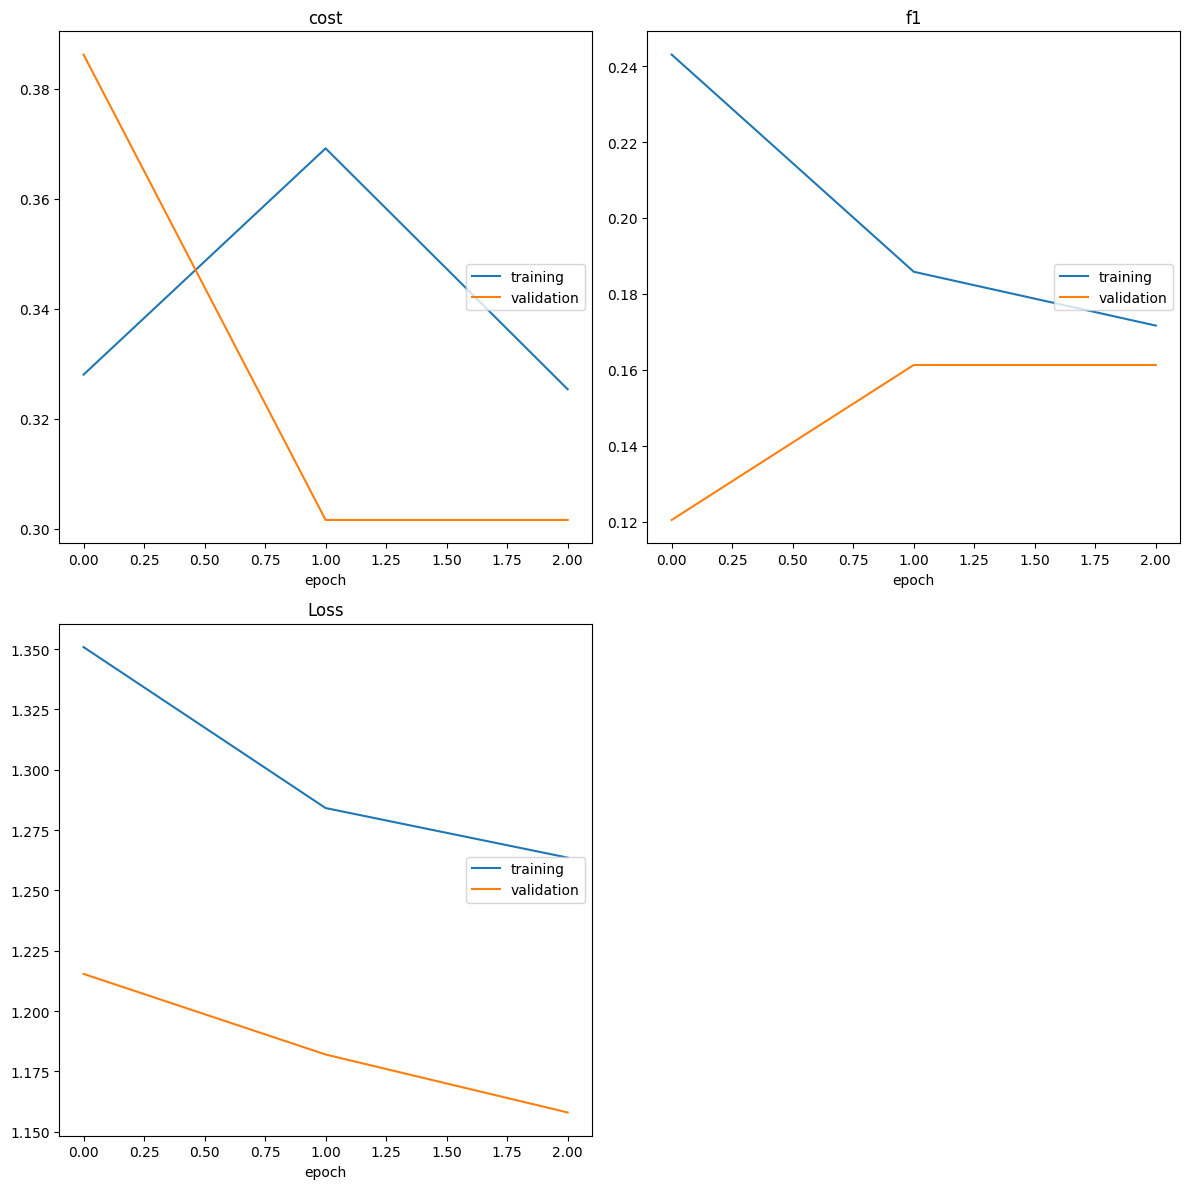

cost
	training         	 (min:    0.325, max:    0.369, cur:    0.325)
	validation       	 (min:    0.302, max:    0.386, cur:    0.302)
f1
	training         	 (min:    0.172, max:    0.243, cur:    0.172)
	validation       	 (min:    0.120, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    1.264, max:    1.351, cur:    1.264)
	validation       	 (min:    1.158, max:    1.215, cur:    1.158)
Train Loss: 1.2636, F1: 0.1717, Cost: 0.3254
Val Loss: 1.1580, F1: 0.1613, Cost: 0.3016
Model saved to /mounts/grupo1/task_1/model_epoch_3.pth

Epoch 4/24


Training:  44%|████▍     | 14/32 [25:48<33:21, 111.21s/it]

In [ ]:
# from yolomodel import ClipStyleMultiStreamClassifierYolo

model = ClipStyleMultiStreamClassifierYolo(class_prompts=[
  "a video of a novice surgeon performing suturing",
  "a video of an intermediate surgeon suturing",
  "a video of a proficient surgeon suturing",
  "a video of an expert surgeon suturing"
],yolo_model_path='/mounts/grupo1/yolo_models/yolo11x.pt')
# train the model
save_dir = '/mounts/grupo1/task_1'
# frames_2d = torch.randn(BATCH_SIZE, NUM_2D_FRAMES, 3, 224, 224)       # (B, T, C, H, W)
# clips_3d  = torch.randn(BATCH_SIZE, NUM_3D_CLIPS, 3, FRAMES_PER_CLIP, 224, 224)   # (B, S, C, T, H, W)
# yolo = torch.randn(BATCH_SIZE, 3, 640, 640)  # (B, C, H, W)
# print(summary(model, input_data=[frames_2d, clips_3d, yolo], depth=3, col_names=["input_size", "output_size", "num_params"]))
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=24,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


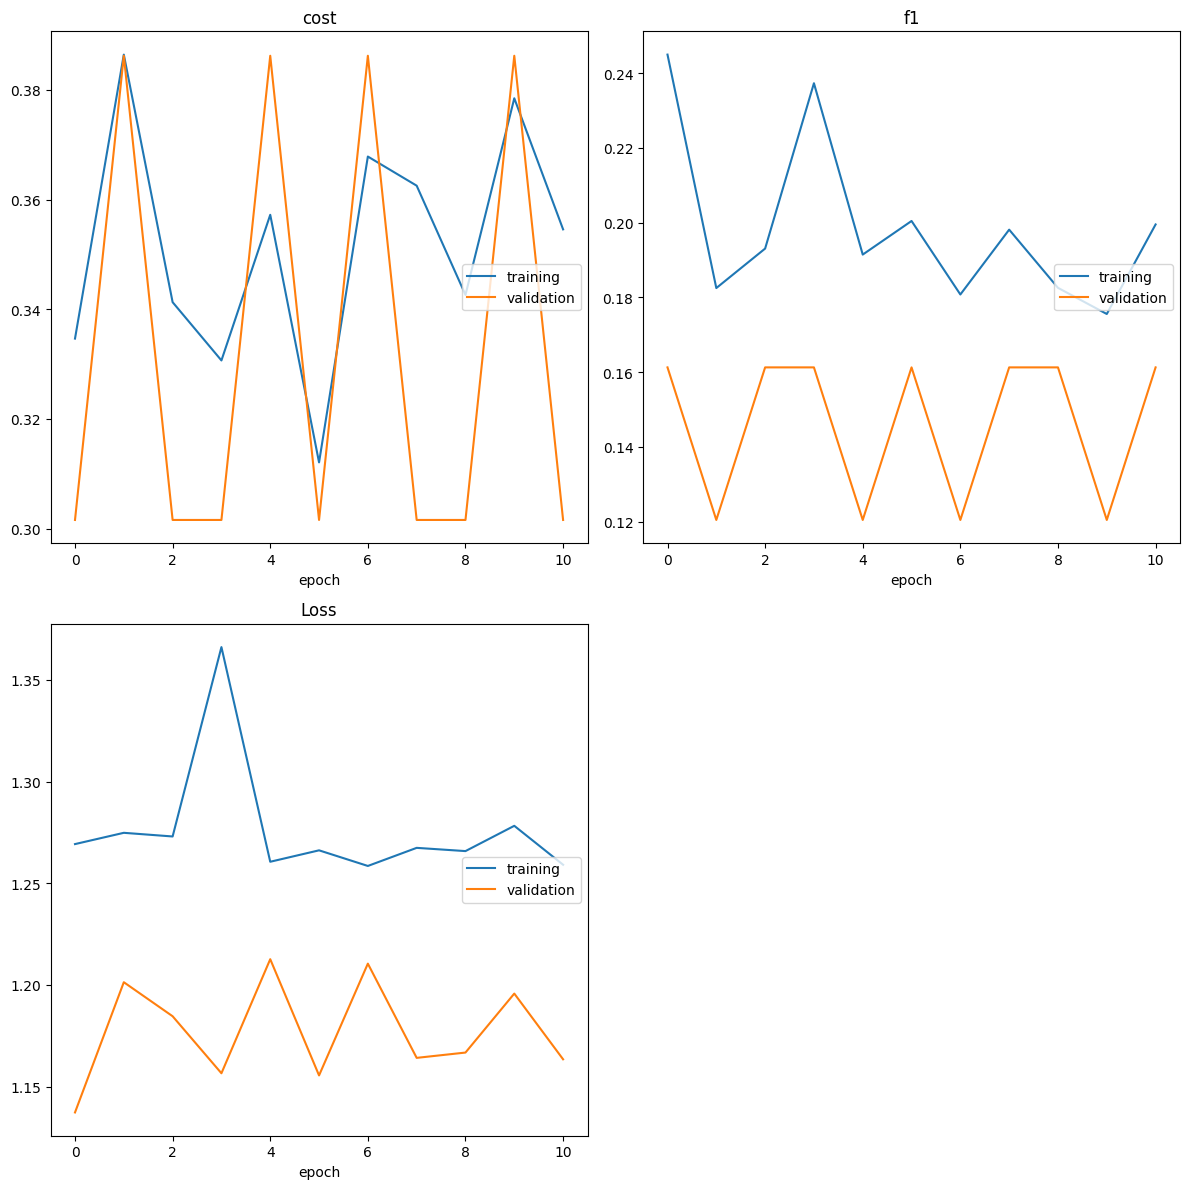

cost
	training         	 (min:    0.312, max:    0.386, cur:    0.355)
	validation       	 (min:    0.302, max:    0.386, cur:    0.302)
f1
	training         	 (min:    0.176, max:    0.245, cur:    0.200)
	validation       	 (min:    0.120, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    1.259, max:    1.366, cur:    1.259)
	validation       	 (min:    1.137, max:    1.213, cur:    1.163)
Train Loss: 1.2591, F1: 0.1995, Cost: 0.3546
Val Loss: 1.1635, F1: 0.1613, Cost: 0.3016
Model saved to /mounts/grupo1/task_1_second/model_epoch_11.pth

Epoch 12/19


Training:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Load model from epoch 3
checkpoint_path = "/mounts/grupo1/task_1/model_epoch_5.pth"
checkpoint = torch.load(checkpoint_path)

model = ClipStyleMultiStreamClassifierYolo(
    class_prompts=[
        "a video of a novice surgeon performing suturing",
        "a video of an intermediate surgeon suturing",
        "a video of a proficient surgeon suturing",
        "a video of an expert surgeon suturing"
    ],
    yolo_model_path='/mounts/grupo1/yolo_models/yolo11x.pt'
)

# Load weights only
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Train for 21 more epochs (from epoch 4 to 24)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=19,  # 24 total - already trained for 3
    lr=0.001,
    weight_decay=1e-4,
    save_dir='/mounts/grupo1/task_1_second',
    num_classes=4
)

# Save final model
torch.save(model.state_dict(), "/mounts/grupo1/task_1_second/final_model.pth")
if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


## Second

In [5]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

# --- Temporal Transformer ---
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # (B, D) pooled over time

# --- Cross Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1 + S, D)
        x = self.encoder(x)
        return x[:, 0]  # return query token

# --- Main Model with MLP Classifier ---
class ClipStyleMultiStreamClassifierYoloMLP(nn.Module):
    def __init__(self, num_classes=4, text_model="ViT-B-32", visual_dim=512, yolo_model_path='yolo11n.pt'):
        super().__init__()
        self.num_classes = num_classes

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer(text_model)
        self.clip_dim = self.clip_model.visual.output_dim

        for p in self.clip_model.parameters():
            p.requires_grad = True  # Unfreeze CLIP visual encoder

        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512
        for p in self.r3d.parameters():
            p.requires_grad = True  # Unfreeze R3D

        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False  # YOLO remains frozen

        self.yolo_feat = None
        self._register_yolo_hook()

        # Dummy pass to determine YOLO output dim
        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook failed"
        self.yolo_dim = self.yolo_feat.shape[1]

        # --- Projection Layers ---
        self.clip_proj = nn.Linear(self.clip_dim, visual_dim)
        self.r3d_proj = nn.Linear(self.r3d_dim, visual_dim)
        self.yolo_proj = nn.Linear(self.yolo_dim, visual_dim)

        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim)
        self.cross_fusion = CrossTransformer(dim=visual_dim)

        # --- MLP Classifier Head ---
        self.classifier = nn.Sequential(
            nn.LayerNorm(visual_dim),
            nn.ReLU(),
            nn.Linear(visual_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Final logits
        )

    def _register_yolo_hook(self):
        def hook_fn(module, input, output):
            self.yolo_feat = output
        # Safe layer for YOLOv8/11
        target_layer = list(self.yolo_model.model.modules())[2]
        target_layer.register_forward_hook(hook_fn)

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        device = frames_2d.device

        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)

        # --- YOLO ---
        yolo_feats = []
        for i in range(B):
            self.yolo_feat = None
            _ = self.yolo_model(yolo_frames[i].unsqueeze(0).to(device))
            assert self.yolo_feat is not None
            pooled = self.yolo_feat.mean(dim=[2, 3])
            yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)  # (B, 1, D)

        # --- Fusion ---
        context = torch.cat([r3d_feats, yolo_feats], dim=1)  # (B, S+1, D)
        fused = self.cross_fusion(temporal_summary, context)  # (B, D)

        # --- MLP Head ---
        logits = self.classifier(fused)  # (B, num_classes)
        return logits


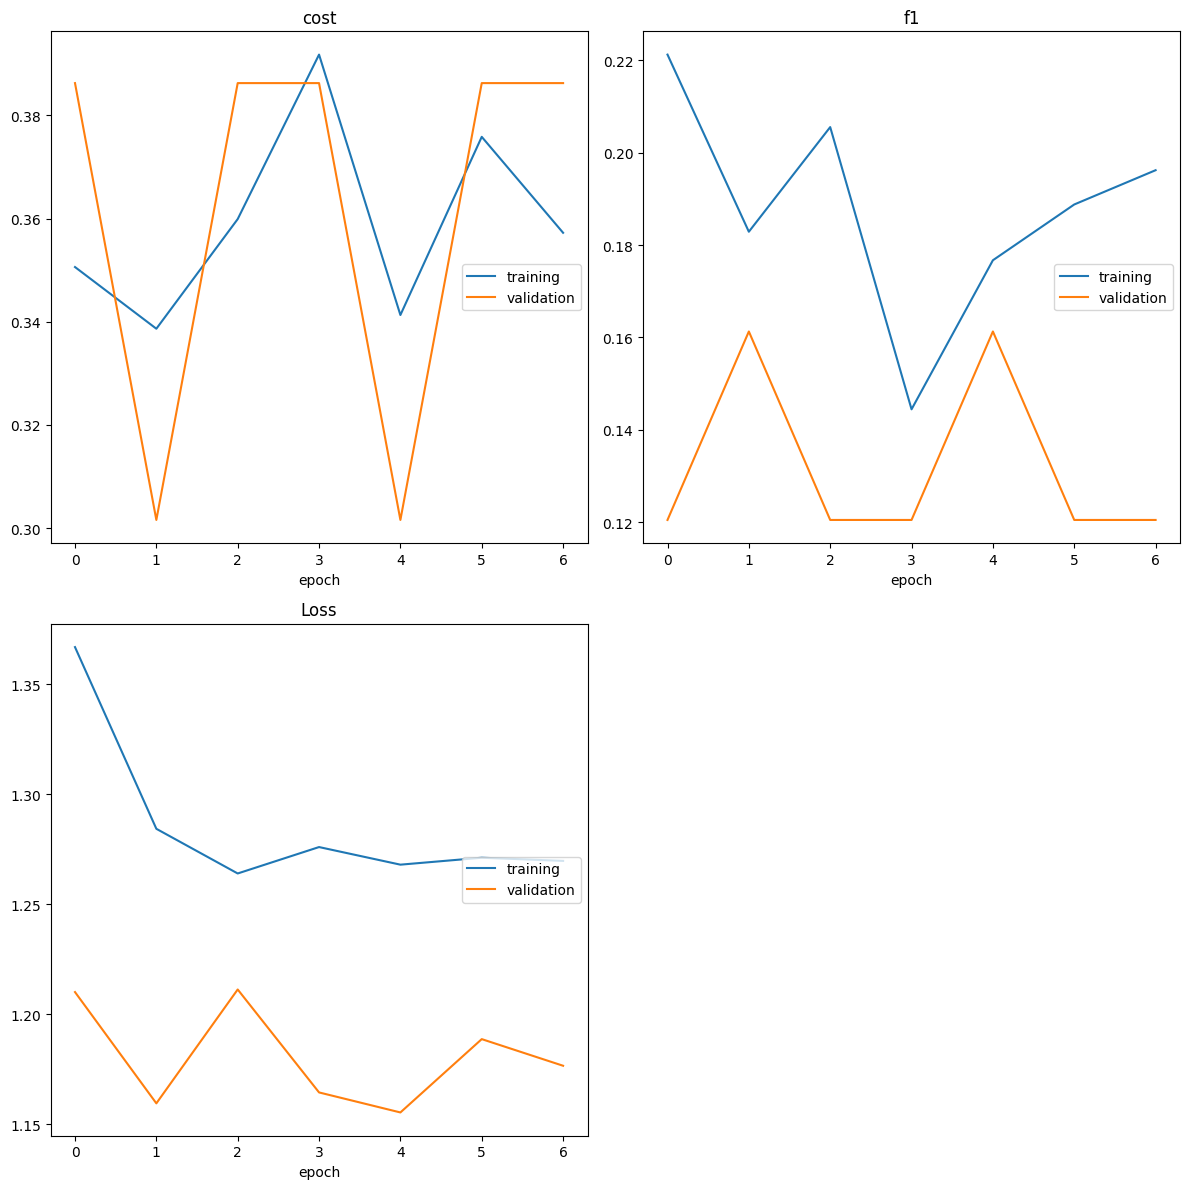

cost
	training         	 (min:    0.339, max:    0.392, cur:    0.357)
	validation       	 (min:    0.302, max:    0.386, cur:    0.386)
f1
	training         	 (min:    0.144, max:    0.221, cur:    0.196)
	validation       	 (min:    0.120, max:    0.161, cur:    0.120)
Loss
	training         	 (min:    1.264, max:    1.367, cur:    1.270)
	validation       	 (min:    1.155, max:    1.211, cur:    1.177)
Train Loss: 1.2698, F1: 0.1962, Cost: 0.3572
Val Loss: 1.1766, F1: 0.1205, Cost: 0.3862
Model saved to /mounts/grupo1/task_1_second_model/model_epoch_7.pth

Epoch 8/50


Training:  19%|█▉        | 12/63 [11:17<46:58, 55.26s/it] 

In [ ]:
model = ClipStyleMultiStreamClassifierYoloMLP(yolo_model_path='/mounts/grupo1/yolo_models/yolo11n.pt',visual_dim=1024)
# train the model
save_dir = '/mounts/grupo1/task_1_second_model'
# frames_2d  # (B, T, C, H, W)
# clips_3d # (B, S, C, T, H, W)
# yolo (B, C, H, W)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=50,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


## Third ( no yolo )

In [8]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

# --- Temporal Transformer ---
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # (B, D) pooled over time

# --- Cross Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1 + S, D)
        x = self.encoder(x)
        return x[:, 0]  # return query token

# --- Main Model with MLP Classifier ---
class ClipStyleMultiStreamClassifierMLP(nn.Module):
    def __init__(self, num_classes=4, text_model="ViT-B-32", visual_dim=512, yolo_model_path='yolo11n.pt'):
        super().__init__()
        self.num_classes = num_classes

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer(text_model)
        self.clip_dim = self.clip_model.visual.output_dim

        for p in self.clip_model.parameters():
            p.requires_grad = True  # Unfreeze CLIP visual encoder

        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512
        for p in self.r3d.parameters():
            p.requires_grad = True  # Unfreeze R3D

        """
        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False  # YOLO remains frozen

        self.yolo_feat = None
        self._register_yolo_hook()
        
        
        # Dummy pass to determine YOLO output dim
        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook failed"
        self.yolo_dim = self.yolo_feat.shape[1]
        """
        # --- Projection Layers ---
        self.clip_proj = nn.Linear(self.clip_dim, visual_dim)
        self.r3d_proj = nn.Linear(self.r3d_dim, visual_dim)
        """
        self.yolo_proj = nn.Linear(self.yolo_dim, visual_dim)
        """
        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim)
        self.cross_fusion = CrossTransformer(dim=visual_dim)

        # --- MLP Classifier Head ---
        self.classifier = nn.Sequential(
            nn.LayerNorm(visual_dim),
            nn.ReLU(),
            nn.Linear(visual_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Final logits
        )

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        device = frames_2d.device

        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)

        """
        # --- YOLO ---
        yolo_feats = []
        for i in range(B):
            self.yolo_feat = None
            _ = self.yolo_model(yolo_frames[i].unsqueeze(0).to(device))
            assert self.yolo_feat is not None
            pooled = self.yolo_feat.mean(dim=[2, 3])
            yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)  # (B, 1, D)
        """
        # --- Fusion ---
        context = torch.cat([r3d_feats], dim=1)  # (B, S+1, D)
        fused = self.cross_fusion(temporal_summary, context)  # (B, D)

        # --- MLP Head ---
        logits = self.classifier(fused)  # (B, num_classes)
        return logits


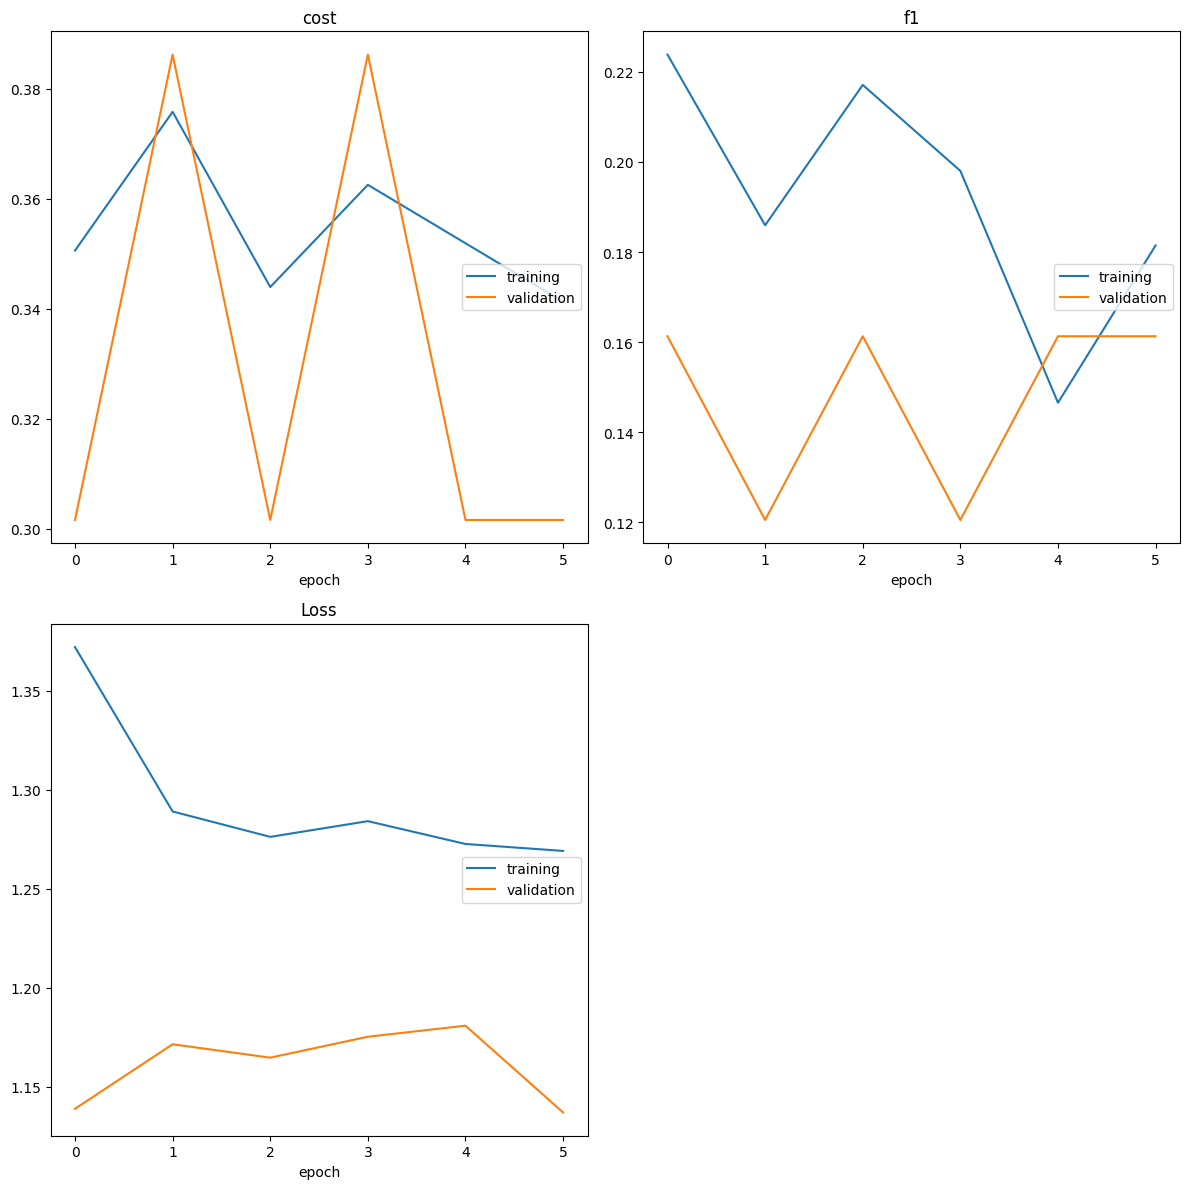

cost
	training         	 (min:    0.341, max:    0.376, cur:    0.341)
	validation       	 (min:    0.302, max:    0.386, cur:    0.302)
f1
	training         	 (min:    0.147, max:    0.224, cur:    0.181)
	validation       	 (min:    0.120, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    1.269, max:    1.372, cur:    1.269)
	validation       	 (min:    1.137, max:    1.181, cur:    1.137)
Train Loss: 1.2691, F1: 0.1815, Cost: 0.3413
Val Loss: 1.1371, F1: 0.1613, Cost: 0.3016
Model saved to /mounts/grupo1/task_1_third_model/model_epoch_6.pth

Epoch 7/20


Training:  86%|████████▌ | 54/63 [50:09<08:21, 55.72s/it] 


KeyboardInterrupt: 

In [9]:
model = ClipStyleMultiStreamClassifierMLP(visual_dim=1024)
# train the model
save_dir = '/mounts/grupo1/task_1_third_model'
# frames_2d  # (B, T, C, H, W)
# clips_3d # (B, S, C, T, H, W)
# yolo (B, C, H, W)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


## Just clip

In [16]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

# --- Temporal Transformer ---
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # (B, D) pooled over time

# --- Cross Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1 + S, D)
        x = self.encoder(x)
        return x[:, 0]  # return query token

# --- Main Model with MLP Classifier ---
class ClipStyleOneStreamClassifierMLP(nn.Module):
    def __init__(self, num_classes=4, text_model="ViT-B-32", visual_dim=512, yolo_model_path='yolo11n.pt'):
        super().__init__()
        self.num_classes = num_classes

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer(text_model)
        self.clip_dim = self.clip_model.visual.output_dim

        for p in self.clip_model.parameters():
            p.requires_grad = True  # Unfreeze CLIP visual encoder

        """
        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512
        for p in self.r3d.parameters():
            p.requires_grad = True  # Unfreeze R3D

        
        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False  # YOLO remains frozen

        self.yolo_feat = None
        self._register_yolo_hook()
        
        
        # Dummy pass to determine YOLO output dim
        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook failed"
        self.yolo_dim = self.yolo_feat.shape[1]
        """
        # --- Projection Layers ---
        self.clip_proj = nn.Linear(self.clip_dim, visual_dim)
        """
        self.r3d_proj = nn.Linear(self.r3d_dim, visual_dim)
        self.yolo_proj = nn.Linear(self.yolo_dim, visual_dim)
        """
        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim)
        self.cross_fusion = CrossTransformer(dim=visual_dim)

        # --- MLP Classifier Head ---
        self.classifier = nn.Sequential(
            nn.LayerNorm(visual_dim),
            nn.ReLU(),
            nn.Linear(visual_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Final logits
        )

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        # S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        device = frames_2d.device

        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        """
        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)
        # --- YOLO ---
        yolo_feats = []
        for i in range(B):
            self.yolo_feat = None
            _ = self.yolo_model(yolo_frames[i].unsqueeze(0).to(device))
            assert self.yolo_feat is not None
            pooled = self.yolo_feat.mean(dim=[2, 3])
            yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)  # (B, 1, D)
        """
        # --- Fusion ---
        # context = torch.cat([r3d_feats], dim=1)  # (B, S+1, D)
        
        B, _, D = temporal_summary.shape
        context = torch.zeros(B, 1, D, device=temporal_summary.device)
        fused = self.cross_fusion(temporal_summary, context)  # (B, D)
        # --- MLP Head ---
        logits = self.classifier(fused)  # (B, num_classes)
        return logits


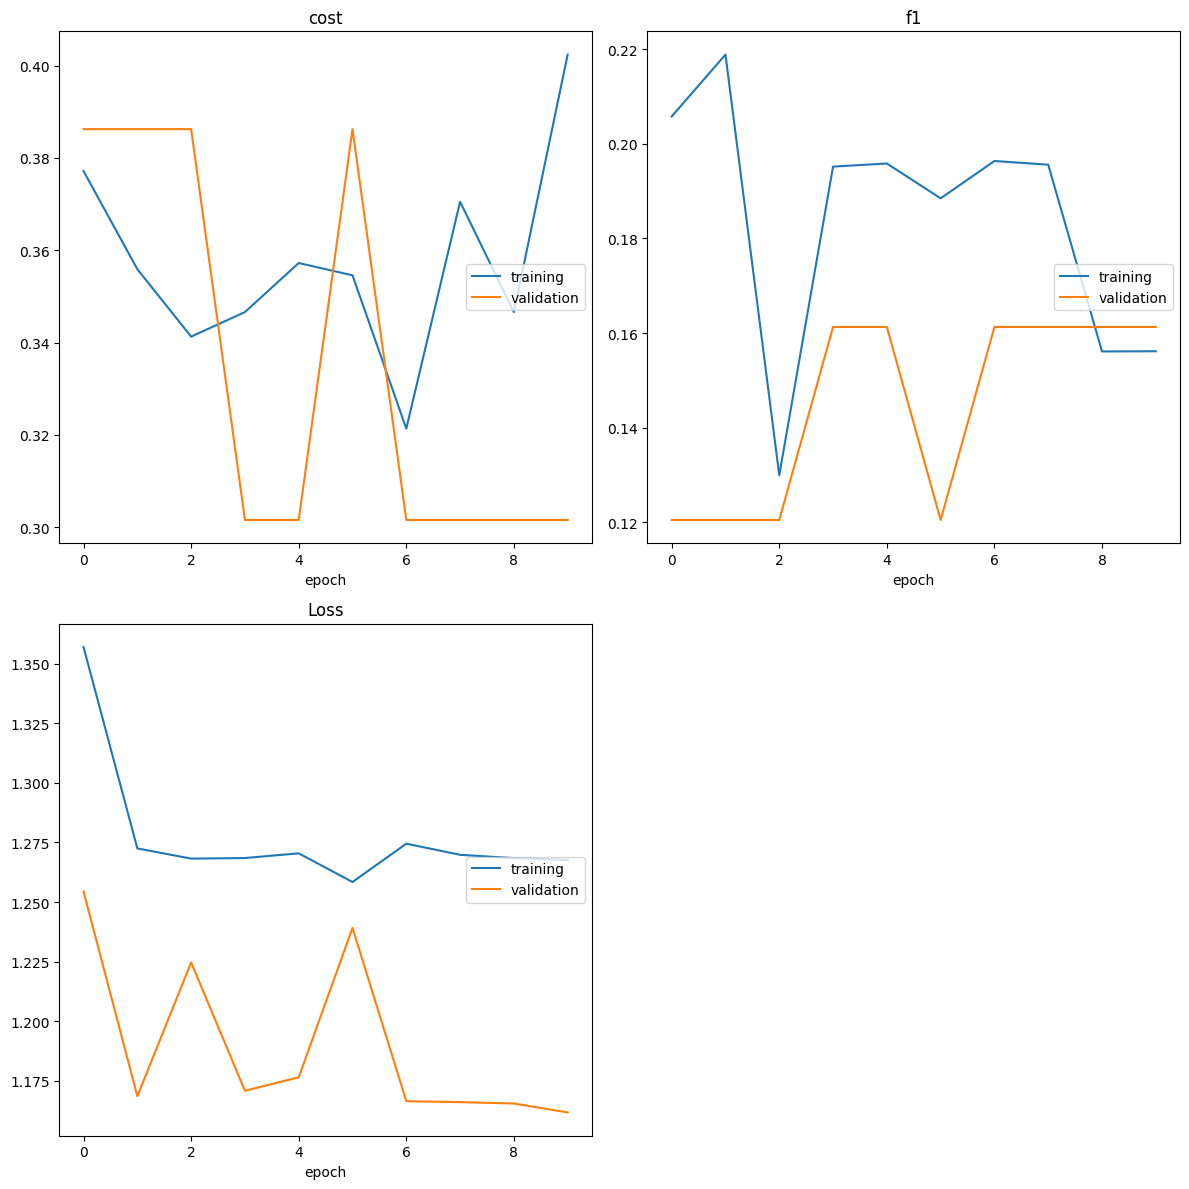

cost
	training         	 (min:    0.321, max:    0.402, cur:    0.402)
	validation       	 (min:    0.302, max:    0.386, cur:    0.302)
f1
	training         	 (min:    0.130, max:    0.219, cur:    0.156)
	validation       	 (min:    0.120, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    1.258, max:    1.357, cur:    1.268)
	validation       	 (min:    1.162, max:    1.254, cur:    1.162)
Train Loss: 1.2677, F1: 0.1562, Cost: 0.4024
Val Loss: 1.1617, F1: 0.1613, Cost: 0.3016
Model saved to /mounts/grupo1/task_1_just_clip/model_epoch_10.pth

Epoch 11/20


Training:  29%|██▊       | 18/63 [16:59<42:28, 56.62s/it]


KeyboardInterrupt: 

In [17]:
model = ClipStyleOneStreamClassifierMLP(visual_dim=1024)
# train the model
save_dir = '/mounts/grupo1/task_1_just_clip'
# frames_2d  # (B, T, C, H, W)
# clips_3d # (B, S, C, T, H, W)
# yolo (B, C, H, W)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


## Make a Larger model

In [5]:
BATCH_SIZE = 2
NUM_2D_FRAMES = 32
NUM_3D_CLIPS = 6
FRAMES_PER_CLIP = 15 

# Define the label mapping to ensure consistency across datasets
LABEL_MAP = {
    "novice": 0,
    "intermediate": 1,
    "proficient": 2,
    "expert": 3
}

# Create CLIP preprocessing
_, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained='laion2b_s34b_b79k')

# Create training dataset
train_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Train/OSATS.xlsx",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
    label_map=LABEL_MAP,
)

# Create test dataset
test_dataset = MultiStreamVideoDataset(
    video_dir="/mounts/OSS_dataset/Train/videos/",
    label_path="/mounts/OSS_dataset/Test/OSATS.csv",
    clip_preprocess=clip_preprocess,
    num_2d_frames=NUM_2D_FRAMES,
    num_3d_clips=NUM_3D_CLIPS,
    frames_per_clip=FRAMES_PER_CLIP,
    label_map=LABEL_MAP,
)

# Split training data into train/validation sets (80%/20%)
train_indices = list(range(len(train_dataset)))
train_idx, val_idx = train_test_split(train_indices, test_size=0.2, random_state=0)

# Create train and validation datasets by subsetting the training dataset
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

print(f"Train: {len(train_subset)} samples, Validation: {len(val_subset)} samples, Test: {len(test_dataset)} samples")

# Create data loaders
train_loader = DataLoader(
    train_subset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)


Found 314 labeled videos
Found 314 labeled videos
Train: 251 samples, Validation: 63 samples, Test: 314 samples


In [6]:
from torchvision.models.video import r3d_18, R3D_18_Weights
from ultralytics import YOLO

# --- Temporal Transformer ---
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.transformer(x)  # (B, T, D)
        return x.mean(dim=1)     # (B, D) pooled over time

# --- Cross Attention Transformer ---
class CrossTransformer(nn.Module):
    def __init__(self, dim, num_heads=4, num_layers=1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_layers)

    def forward(self, query, context):
        x = torch.cat([query, context], dim=1)  # (B, 1 + S, D)
        x = self.encoder(x)
        return x[:, 0]  # return query token

# --- Main Model with MLP Classifier ---
class ClipStyleMultiStreamClassifierYoloMLPLarge(nn.Module):
    def __init__(self, num_classes=4, text_model="ViT-L/14", visual_dim=1024, yolo_model_path='yolo11n.pt'):
        super().__init__()
        self.num_classes = num_classes

        # --- CLIP ---
        self.clip_model, _, _ = open_clip.create_model_and_transforms(text_model, pretrained="laion2b_s34b_b79k")
        self.tokenizer = open_clip.get_tokenizer(text_model)
        self.clip_dim = self.clip_model.visual.output_dim

        for p in self.clip_model.parameters():
            p.requires_grad = True  # Unfreeze CLIP visual encoder

        # --- R3D ---
        self.r3d = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.r3d.fc = nn.Identity()
        self.r3d_dim = 512
        for p in self.r3d.parameters():
            p.requires_grad = True  # Unfreeze R3D

        # --- YOLO ---
        self.yolo_model = YOLO(yolo_model_path).model
        self.yolo_model.eval()
        for p in self.yolo_model.parameters():
            p.requires_grad = False  # YOLO remains frozen

        self.yolo_feat = None
        self._register_yolo_hook()

        # Dummy pass to determine YOLO output dim
        dummy_input = torch.zeros(1, 3, 640, 640)
        with torch.no_grad():
            _ = self.yolo_model(dummy_input)
        assert self.yolo_feat is not None, "YOLO hook failed"
        self.yolo_dim = self.yolo_feat.shape[1]

        # --- Projection Layers ---
        self.clip_proj = nn.Sequential(nn.Linear(self.clip_dim, visual_dim),nn.LayerNorm(visual_dim))
        self.r3d_proj = nn.Sequential(nn.Linear(self.r3d_dim, visual_dim),nn.LayerNorm(visual_dim))
        self.yolo_proj = nn.Sequential(nn.Linear(self.yolo_dim, visual_dim),nn.LayerNorm(visual_dim))

        # --- Transformers ---
        self.temporal = TemporalTransformer(input_dim=visual_dim, num_layers=4, num_heads=4)
        self.cross_fusion = CrossTransformer(dim=visual_dim, num_layers=2, num_heads=4)


        # --- MLP Classifier Head ---
        self.classifier = nn.Sequential(
            nn.LayerNorm(visual_dim),
            nn.ReLU(),
            nn.Linear(visual_dim, 512),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )


    def _register_yolo_hook(self):
        def hook_fn(module, input, output):
            self.yolo_feat = output
        # Safe layer for YOLOv8/11
        target_layer = list(self.yolo_model.model.modules())[2]
        target_layer.register_forward_hook(hook_fn)

    def forward(self, frames_2d, clips_3d, yolo_frames):
        B, T, C, H, W = frames_2d.shape
        S, C3D, T3D, H3D, W3D = clips_3d.shape[1:]
        device = frames_2d.device

        # --- CLIP ---
        frames_flat = frames_2d.view(B * T, C, H, W)
        clip_feats = self.clip_model.encode_image(frames_flat)
        clip_feats = self.clip_proj(clip_feats).view(B, T, -1)
        temporal_summary = self.temporal(clip_feats).unsqueeze(1)  # (B, 1, D)

        # --- R3D ---
        clips_3d = clips_3d.view(B * S, C3D, T3D, H3D, W3D)
        r3d_feats = self.r3d(clips_3d)
        r3d_feats = self.r3d_proj(r3d_feats).view(B, S, -1)  # (B, S, D)

        # --- YOLO ---
        yolo_feats = []
        for i in range(B):
            self.yolo_feat = None
            _ = self.yolo_model(yolo_frames[i].unsqueeze(0).to(device))
            assert self.yolo_feat is not None
            pooled = self.yolo_feat.mean(dim=[2, 3])
            yolo_feats.append(pooled)
        yolo_feats = torch.cat(yolo_feats, dim=0)
        yolo_feats = self.yolo_proj(yolo_feats).unsqueeze(1)  # (B, 1, D)

        # --- Fusion ---
        context = torch.cat([r3d_feats, yolo_feats], dim=1)  # (B, S+1, D)
        fused = self.cross_fusion(temporal_summary, context)  # (B, D)

        # --- MLP Head ---
        logits = self.classifier(fused)  # (B, num_classes)
        return logits


In [14]:
model = ClipStyleMultiStreamClassifierYoloMLP(yolo_model_path='/mounts/grupo1/yolo_models/yolo11n.pt',text_model="ViT-B-32")
# train the model
save_dir = '/mounts/grupo1/task_1_large'
# frames_2d  # (B, T, C, H, W)
# clips_3d # (B, S, C, T, H, W)
# yolo (B, C, H, W)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=50,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.41 GiB of which 2.75 MiB is free. Process 1729112 has 2.19 GiB memory in use. Process 1938357 has 1.65 GiB memory in use. Process 1945111 has 29.91 GiB memory in use. Process 1970063 has 1.93 GiB memory in use. Process 2116846 has 7.31 GiB memory in use. Process 2326631 has 3.96 GiB memory in use. Process 2335151 has 262.00 MiB memory in use. Of the allocated memory 29.36 GiB is allocated by PyTorch, and 184.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

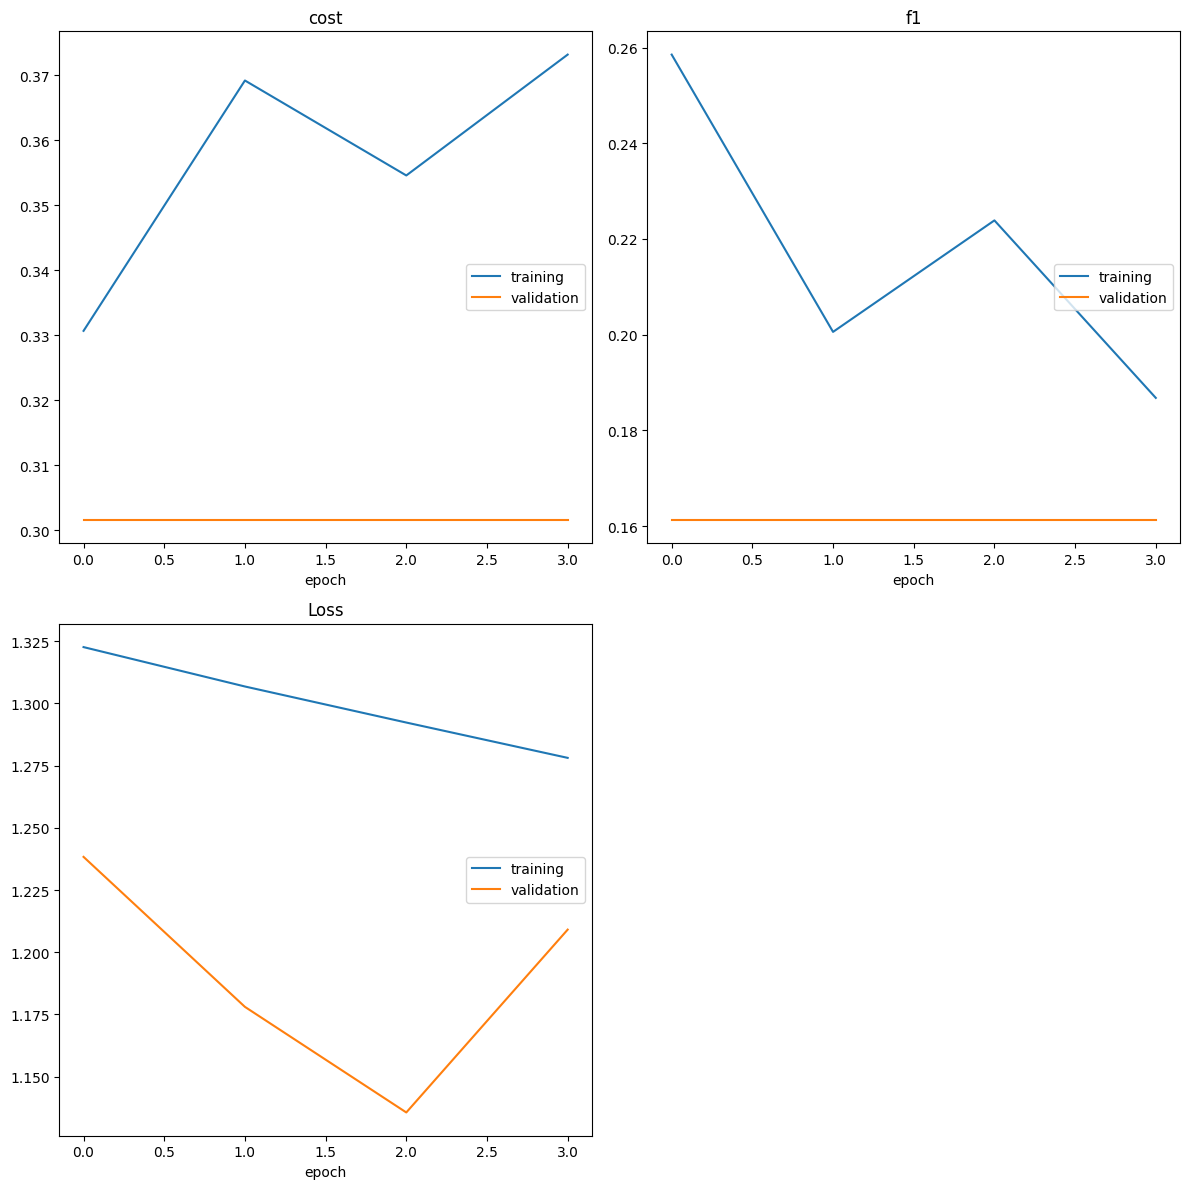

cost
	training         	 (min:    0.331, max:    0.373, cur:    0.373)
	validation       	 (min:    0.302, max:    0.302, cur:    0.302)
f1
	training         	 (min:    0.187, max:    0.259, cur:    0.187)
	validation       	 (min:    0.161, max:    0.161, cur:    0.161)
Loss
	training         	 (min:    1.278, max:    1.323, cur:    1.278)
	validation       	 (min:    1.136, max:    1.238, cur:    1.209)
Train Loss: 1.2781, F1: 0.1868, Cost: 0.3732
Val Loss: 1.2091, F1: 0.1613, Cost: 0.3016
Model saved to /mounts/grupo1/task_1_Large/model_epoch_4.pth

Epoch 5/50


Training:   4%|▍         | 5/126 [02:49<1:08:38, 34.04s/it]

In [ ]:
model = ClipStyleMultiStreamClassifierYoloMLPLarge(yolo_model_path='/mounts/grupo1/yolo_models/yolo11n.pt',text_model="ViT-B-32")
# train the model
save_dir = '/mounts/grupo1/task_1_Large'
# frames_2d  # (B, T, C, H, W)
# clips_3d # (B, S, C, T, H, W)
# yolo (B, C, H, W)
model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=50,
    lr=0.001,
    weight_decay=1e-4,
    save_dir=save_dir,
    num_classes=4
)

torch.save(model.state_dict(), f"{save_dir}/final_model.pth")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

del model
del train_loader, val_loader, test_loader

try:
    del train_dataset, test_dataset, train_subset, val_subset
except:
    pass

gc.collect()

print("Training complete and memory cleared!")
